<font size=5> This document includes or references data provided by J.P. Morgan. </font>

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import csv
import time

In [9]:
JPfraud_full = pd.read_csv("data/fraud_payment_data")
JPfraud_full

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498172,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,24701.0,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498173,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,4953.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498174,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,34784.0,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498175,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,23822.0,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [10]:
JPfraud_full = JPfraud_full.drop(labels=['Sender_Sector','Sender_lob'],axis=1)
JPfraud_full['Time_step'] = pd.to_datetime(JPfraud_full['Time_step'],format='%Y-%m-%d %H:%M:%S')
JPfraud_full

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...
1498172,2054-09-14 13:17:24,PAY-BILL-2180018,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,159.64,0,MAKE-PAYMENT
1498173,2054-09-15 00:57:24,QUICK-PAYMENT-2181421,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,CLIENT-2181279,ACCOUNT-2181280,USA,120.07,0,QUICK-PAYMENT
1498174,2054-09-15 01:17:24,PAYMENT-2180021,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,25.32,0,MAKE-PAYMENT
1498175,2054-09-15 12:57:24,QUICK-PAYMENT-2181422,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,CLIENT-2181279,ACCOUNT-2181280,USA,610.91,0,QUICK-PAYMENT


In [11]:
type(JPfraud_full.Time_step.iloc[12345])

pandas._libs.tslibs.timestamps.Timestamp

In [12]:
JPfraud_full.Time_step.mean()

Timestamp('2038-06-16 16:05:19.737899520')

In [13]:
JPfraud = JPfraud_full[:500000]
JPfraud

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK
...,...,...,...,...,...,...,...,...,...,...,...
499995,2032-12-06 10:55:07,QUICK-PAYMENT-727369,CLIENT-727191,ACCOUNT-727192,USA,JPMC-CLIENT-727105,ACCOUNT-727116,USA,521.89,0,QUICK-PAYMENT
499996,2032-12-06 10:55:07,PAY-CHECK-721411,JPMC-CLIENT-721145,ACCOUNT-721159,USA,CLIENT-721146,ACCOUNT-721157,USA,148.32,0,PAY-CHECK
499997,2032-12-06 11:05:07,QUICK-PAYMENT-727371,JPMC-CLIENT-727105,ACCOUNT-727115,USA,CLIENT-727191,ACCOUNT-727192,USA,461.52,0,QUICK-PAYMENT
499998,2032-12-06 11:05:07,MOVE-FUNDS-721413,JPMC-CLIENT-721145,ACCOUNT-721175,USA,JPMC-CLIENT-721148,ACCOUNT-721154,ANTARCTICA,866.33,0,MOVE-FUNDS


In [14]:
JPfraud.Transaction_Type.value_counts()

Transaction_Type
MAKE-PAYMENT     186450
QUICK-PAYMENT     73058
MOVE-FUNDS        60142
DEPOSIT-CASH      36464
DEPOSIT-CHECK     36357
PAY-CHECK         36041
EXCHANGE          35943
WITHDRAWAL        35545
Name: count, dtype: int64

In [15]:
JPfraud.Label.value_counts(normalize=True)

Label
0    0.979598
1    0.020402
Name: proportion, dtype: float64

In [16]:
print(JPfraud.Sender_Id.value_counts())
print()
print(JPfraud.Bene_Id.value_counts())

Sender_Id
JPMC-CLIENT-303611     155
JPMC-CLIENT-360470     154
JPMC-CLIENT-456840     152
JPMC-CLIENT-343036     152
JPMC-CLIENT-437630     152
                      ... 
BILL-COMPANY-174247      1
JPMC-COMPANY-451923      1
COMPANY-181929           1
BILL-COMPANY-176535      1
BILL-COMPANY-724797      1
Name: count, Length: 19594, dtype: int64

Bene_Id
JPMC-CLIENT-599198     79
JPMC-CLIENT-730151     79
JPMC-CLIENT-198756     78
JPMC-CLIENT-507183     77
JPMC-CLIENT-108724     77
                       ..
BILL-COMPANY-331911     1
BILL-COMPANY-336984     1
BILL-COMPANY-336021     1
BILL-COMPANY-334277     1
BILL-COMPANY-723721     1
Name: count, Length: 93177, dtype: int64


In [17]:
# Do unique accounts have multiple Sender or Beneficiary countries?
sender_pairs = JPfraud[['Sender_Id','Sender_Country']].dropna().drop_duplicates()
sender_pairs.sort_values(by='Sender_Id',inplace=True,ascending=True)
sender_pairs = sender_pairs.reset_index(drop=True)
sender_pairs

,Sender_Id,Sender_Country
0,BILL-COMPANY-100003,USA
1,BILL-COMPANY-100082,SAINT-LUCIA
2,BILL-COMPANY-100311,HAITI
3,BILL-COMPANY-10046,USA
4,BILL-COMPANY-100490,USA
...,...,...
20798,JPMC-COMPANY-98189,GHANA
20799,JPMC-COMPANY-98470,MALAYSIA
20800,JPMC-COMPANY-98472,GERMANY
20801,JPMC-COMPANY-99062,GERMANY


In [18]:
sender_pairs[sender_pairs.duplicated(subset='Sender_Id',keep=False)]

,Sender_Id,Sender_Country
13914,JPMC-CLIENT-100165,USA
13915,JPMC-CLIENT-100165,KENYA
13921,JPMC-CLIENT-101582,USA
13922,JPMC-CLIENT-101582,SLOVENIA
13937,JPMC-CLIENT-103239,TUVALU
...,...,...
18898,JPMC-CLIENT-96995,USA
18901,JPMC-CLIENT-97305,USA
18902,JPMC-CLIENT-97305,AUSTRIA
18919,JPMC-CLIENT-99625,USA


In [19]:
len(JPfraud.Transaction_Id.unique())

500000

<font size=8>Checking for which transactions have NaNs </font>

In [21]:
JPfraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Time_step         500000 non-null  datetime64[ns]
 1   Transaction_Id    500000 non-null  object        
 2   Sender_Id         427179 non-null  object        
 3   Sender_Account    427179 non-null  object        
 4   Sender_Country    427179 non-null  object        
 5   Bene_Id           428512 non-null  object        
 6   Bene_Account      428512 non-null  object        
 7   Bene_Country      428512 non-null  object        
 8   USD_amount        500000 non-null  float64       
 9   Label             500000 non-null  int64         
 10  Transaction_Type  500000 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 42.0+ MB


In [22]:
JPfraud.isna().sum()

Time_step               0
Transaction_Id          0
Sender_Id           72821
Sender_Account      72821
Sender_Country      72821
Bene_Id             71488
Bene_Account        71488
Bene_Country        71488
USD_amount              0
Label                   0
Transaction_Type        0
dtype: int64

In [23]:
# Indicating only depositing transactions have NaN's for Sender_Id
JPfraud[((JPfraud.Sender_Id.isnull()) & ~((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type


In [24]:
print('Number of DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK'))]))
print('Number of NaNs in Sender_Id for DEPOSIT-CASH, DEPOSIT-CHECK transactions', len(JPfraud[((JPfraud.Sender_Id.isna()) & ((JPfraud.Transaction_Type == 'DEPOSIT-CASH') |
                                             (JPfraud.Transaction_Type == 'DEPOSIT-CHECK')))]))

Number of DEPOSIT-CASH, DEPOSIT-CHECK transactions 72821
Number of NaNs in Sender_Id for DEPOSIT-CASH, DEPOSIT-CHECK transactions 72821


In [25]:
print('Number of WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                             (JPfraud.Transaction_Type == 'EXCHANGE'))]))
print('Number of nulls in Bene_Id for WITHDRAWAL, EXCHANGE transactions', len(JPfraud[((JPfraud.Bene_Id.isnull()) &
                                                                                            ((JPfraud.Transaction_Type == 'WITHDRAWAL') |
                                                                                             (JPfraud.Transaction_Type == 'EXCHANGE')))]))

Number of WITHDRAWAL, EXCHANGE transactions 71488
Number of nulls in Bene_Id for WITHDRAWAL, EXCHANGE transactions 71488


<font size=4> **Conclusion:** *There's not any "missing data." Deposits (DEPOSIT-CASH, DEPOSIT-CHECK) only have Beneficiary account identifications, and withdrawals/exchanges only have Sender account identifications.*</font>

<font size=6> Comparing transaction amount and number of fraudulent transactions detected </font>

In [28]:
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()

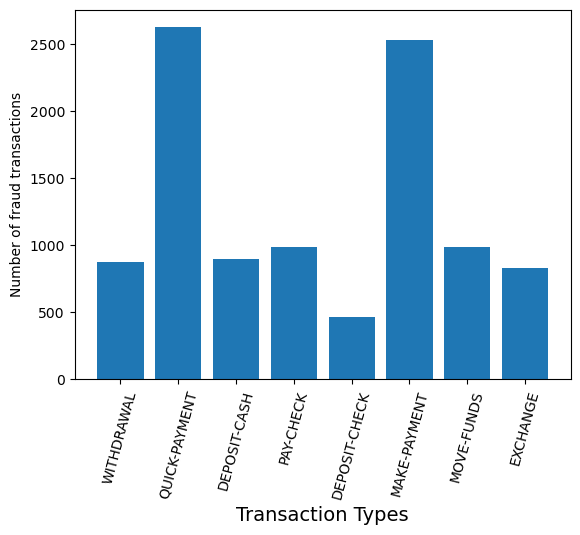

In [29]:
plt.figure()

plt.bar(trans_types, fraud_number)
plt.xlabel('Transaction Types',fontsize=14)
plt.ylabel('Number of fraud transactions',fontsize=10)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)

plt.show()

In [30]:
print('Max USD amount:', JPfraud.USD_amount.max())
print('Min USD amount:', JPfraud.USD_amount.min())

Max USD amount: 19927.99
Min USD amount: 0.0


In [31]:
JPfraud.loc[JPfraud.Label == 1].USD_amount.describe()

count    10201.000000
mean       819.519502
std       1907.635796
min        100.000000
25%        255.140000
50%        513.240000
75%        776.110000
max      19927.990000
Name: USD_amount, dtype: float64

In [32]:
JPfraud.loc[JPfraud.Label == 0].USD_amount.describe()

count    489799.000000
mean        507.129661
std         462.088705
min           0.000000
25%         135.860000
50%         402.010000
75%         733.340000
max       19838.380000
Name: USD_amount, dtype: float64

In [33]:
bin_labels = []
for i in np.arange(40):
    bin_labels.append(str(i*500) + '-' + str(i*500 + 500))

print(bin_labels)
print()
print(len(bin_labels))

['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-3500', '3500-4000', '4000-4500', '4500-5000', '5000-5500', '5500-6000', '6000-6500', '6500-7000', '7000-7500', '7500-8000', '8000-8500', '8500-9000', '9000-9500', '9500-10000', '10000-10500', '10500-11000', '11000-11500', '11500-12000', '12000-12500', '12500-13000', '13000-13500', '13500-14000', '14000-14500', '14500-15000', '15000-15500', '15500-16000', '16000-16500', '16500-17000', '17000-17500', '17500-18000', '18000-18500', '18500-19000', '19000-19500', '19500-20000']

40


In [34]:
JPfraud_label1 = JPfraud[JPfraud.Label == 1].reset_index(drop=True,inplace=False)
JPfraud_label1['amount_range'] = pd.cut(JPfraud_label1['USD_amount'],np.linspace(0,20000,41), labels=bin_labels)
JPfraud_label1

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,amount_range
0,2022-03-15 10:24:00,QUICK-PAYMENT-8964,JPMC-CLIENT-8947,ACCOUNT-8957,USA,CLIENT-8965,ACCOUNT-8966,BENIN,857.13,1,QUICK-PAYMENT,500-1000
1,2022-03-15 22:54:00,DEPOSIT-CASH-2517,NaN,NaN,NaN,JPMC-CLIENT-2492,ACCOUNT-2502,USA,684.52,1,DEPOSIT-CASH,500-1000
2,2022-03-15 23:04:00,PAY-BILL-2521,JPMC-CLIENT-2492,ACCOUNT-2503,USA,JPMC-COMPANY-2495,ACCOUNT-2501,USA,787.80,1,MAKE-PAYMENT,500-1000
3,2022-03-15 23:14:00,WITHDRAWAL-2519,JPMC-CLIENT-2492,ACCOUNT-2502,USA,NaN,NaN,NaN,194.67,1,WITHDRAWAL,0-500
4,2022-03-16 11:14:00,MOVE-FUNDS-2522,JPMC-CLIENT-2492,ACCOUNT-2503,USA,JPMC-COMPANY-2494,ACCOUNT-2500,ALAND-ISLANDS,812.27,1,MOVE-FUNDS,500-1000
...,...,...,...,...,...,...,...,...,...,...,...,...
10196,2032-11-29 05:15:07,QUICK-PAYMENT-727016,JPMC-CLIENT-726818,ACCOUNT-726833,USA,JPMC-CLIENT-726820,ACCOUNT-726830,USA,501.82,1,QUICK-PAYMENT,500-1000
10197,2032-11-29 07:35:07,PAY-CHECK-721077,JPMC-CLIENT-720859,ACCOUNT-720871,USA,CLIENT-720861,ACCOUNT-720875,ANTIGUA-BARBUDA,599.43,1,PAY-CHECK,500-1000
10198,2032-11-29 07:45:07,QUICK-PAYMENT-721075,CLIENT-720861,ACCOUNT-720875,ANTIGUA-BARBUDA,JPMC-CLIENT-720859,ACCOUNT-720870,USA,536.86,1,QUICK-PAYMENT,500-1000
10199,2032-11-29 19:45:07,PAY-BILL-721073,JPMC-CLIENT-720859,ACCOUNT-720870,USA,BILL-COMPANY-720954,ACCOUNT-720955,USA,747.83,1,MAKE-PAYMENT,500-1000


In [35]:
amount_counts = np.zeros(len(bin_labels))

for i, amount in enumerate(bin_labels):
    amount_counts[i] = JPfraud_label1.amount_range.isin([amount]).sum()

amount_counts

array([4.956e+03, 4.942e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
       1.780e+02, 1.400e+01, 2.000e+00, 7.000e+00, 1.000e+01, 5.000e+00,
       4.000e+00, 5.000e+00, 8.000e+00, 7.000e+00, 5.000e+00, 7.000e+00,
       4.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 4.000e+00, 4.000e+00,
       6.000e+00, 4.000e+00, 4.000e+00, 6.000e+00])

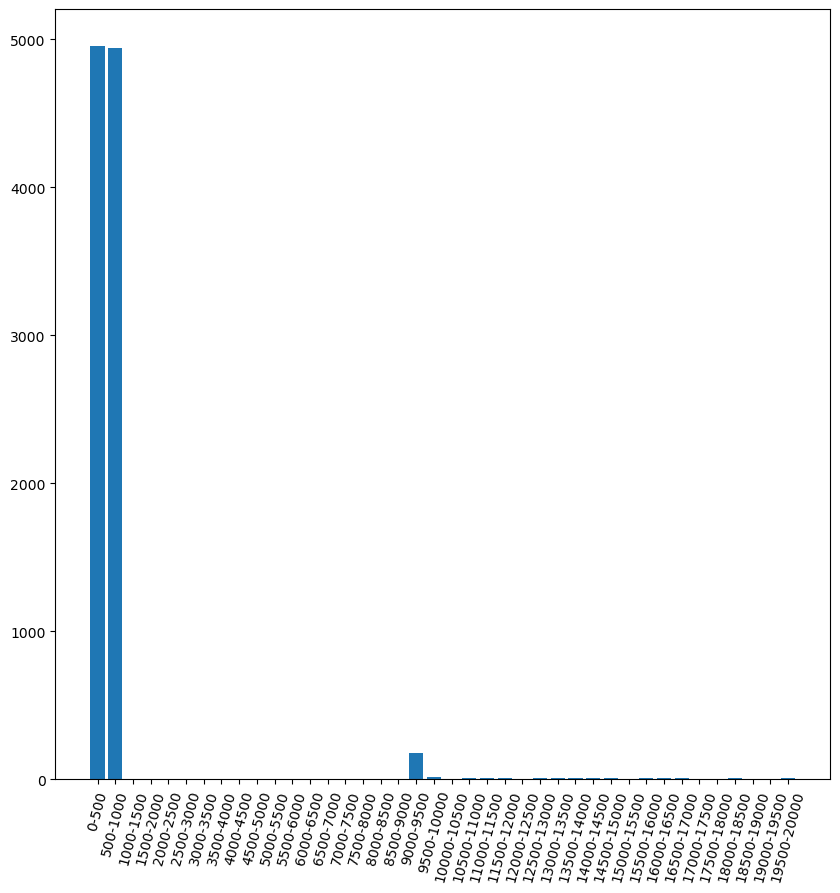

In [36]:
plt.figure(figsize=(10,10))
plt.bar(bin_labels,amount_counts)
plt.xticks(np.arange(len(bin_labels)),bin_labels,rotation=75)
plt.show()

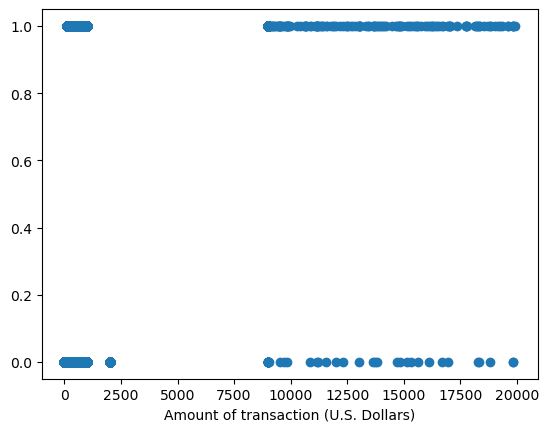

In [37]:
plt.figure()
plt.scatter(JPfraud.USD_amount,JPfraud.Label)
plt.xlabel('Amount of transaction (U.S. Dollars)')
#plt.ylabel('Not Fraud/Fraud')
plt.show()

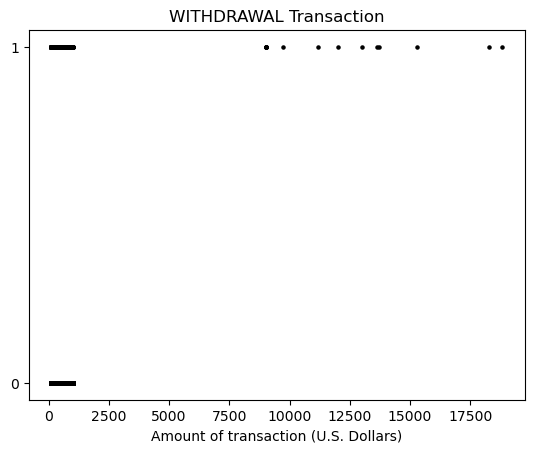

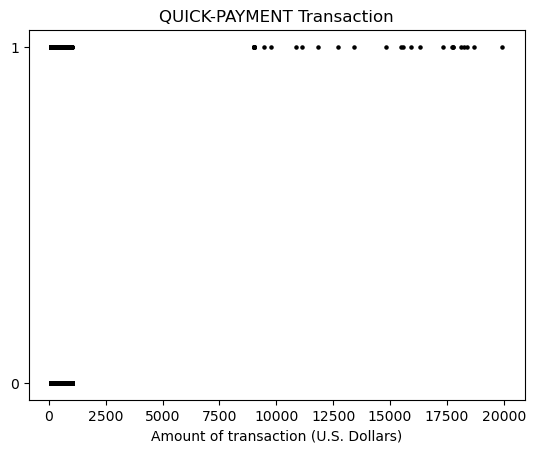

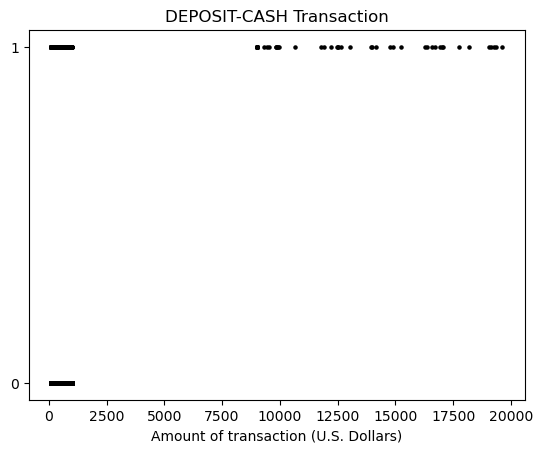

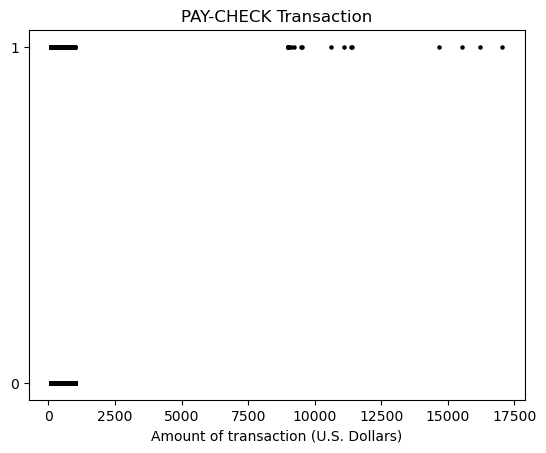

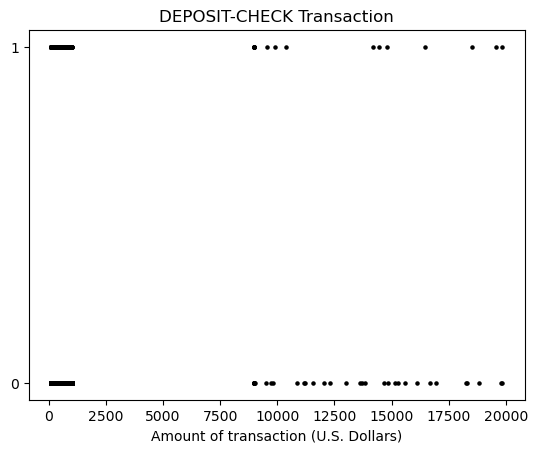

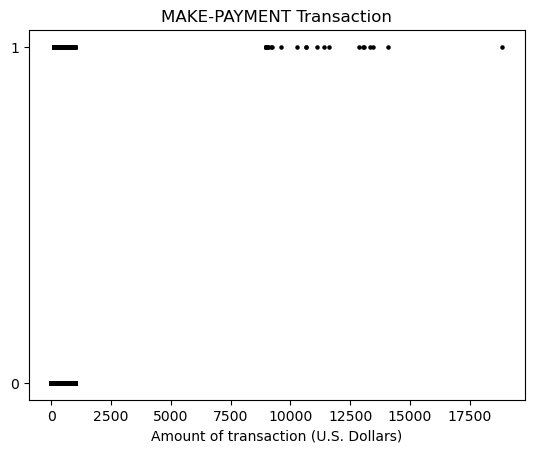

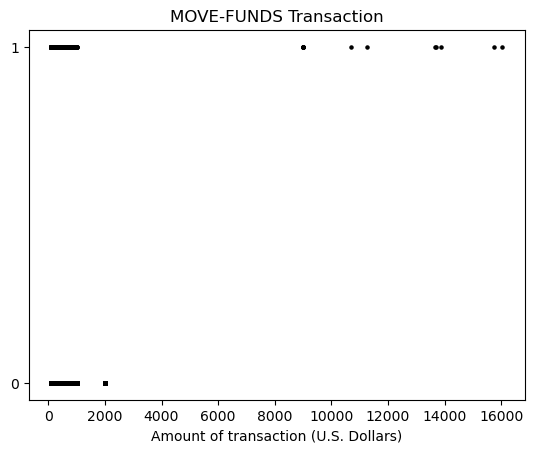

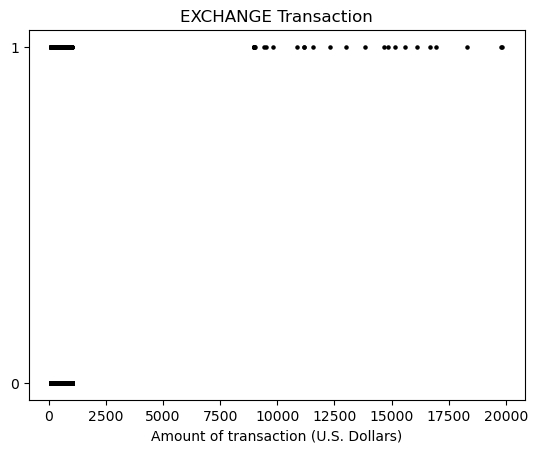

In [38]:
trans_type = JPfraud.Transaction_Type.unique()

for trans in trans_type:
    plt.figure()
    plt.scatter(JPfraud.loc[JPfraud.Transaction_Type == trans].USD_amount,JPfraud.loc[JPfraud.Transaction_Type == trans].Label,s=5,color='black',marker='o')
    #plt.ylabel('Not Fraud/Fraud')
    plt.xlabel('Amount of transaction (U.S. Dollars)')
    plt.yticks([0,1])
    plt.title(trans + ' Transaction')
    plt.show()

<font size=6> Distribution of time </font>

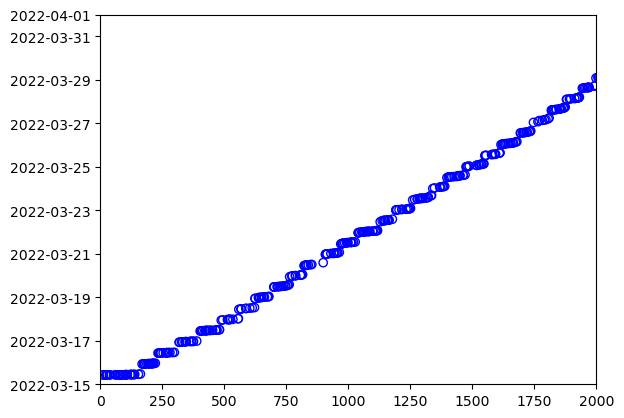

In [40]:
plt.figure()
JPfraud_timeplot = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot.index,JPfraud_timeplot.Time_step,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([0,2000])
plt.ylim([dt.datetime(2022,3,15,0,0,0),dt.datetime(2022,4,1,0,0,0)])
plt.show()

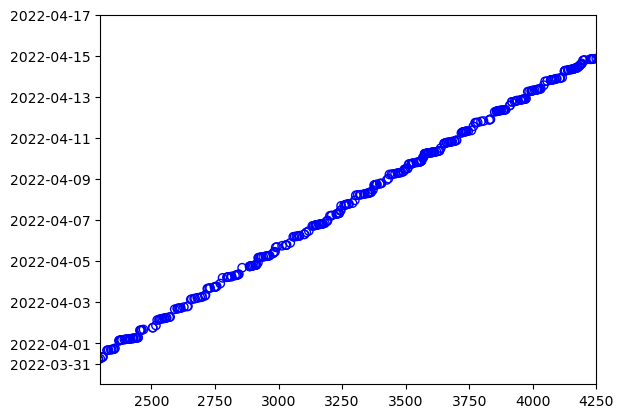

In [41]:
plt.figure()
JPfraud_timeplot2 = JPfraud.sample(100000,random_state=12345)
plt.scatter(JPfraud_timeplot2.index,JPfraud_timeplot2.Time_step,marker='o',facecolor='None',edgecolor='blue')
plt.xlim([2300,4250])
plt.ylim([dt.datetime(2022,3,30,0,0,0),dt.datetime(2022,4,17,0,0,0)])
plt.show()

In [42]:
JPfraud.Time_step.value_counts().head(40)

Time_step
2023-08-28 13:04:09    100
2027-10-12 02:14:35    100
2023-03-04 07:34:06     99
2030-08-11 02:14:53     99
2024-08-09 12:34:15     99
2024-10-09 01:34:16     99
2029-01-13 17:34:43     99
2027-08-15 12:14:34     98
2029-05-09 22:14:45     98
2031-11-09 18:55:01     98
2032-10-22 07:15:07     98
2022-11-04 17:04:04     98
2028-11-17 15:24:42     98
2023-06-29 11:54:08     97
2027-12-10 14:34:36     97
2028-02-06 16:24:37     97
2027-02-27 15:54:31     97
2023-04-29 11:04:07     97
2028-05-31 21:24:39     97
2031-05-24 00:54:58     97
2029-12-27 04:54:49     96
2031-07-20 03:04:59     96
2027-04-24 19:24:32     96
2030-04-19 09:44:51     96
2024-02-16 18:14:12     96
2030-02-21 07:24:50     96
2032-03-04 10:45:03     96
2030-06-14 00:24:52     96
2026-01-18 14:34:24     96
2031-09-12 18:05:00     96
2028-04-04 19:14:38     96
2023-12-21 16:04:11     96
2029-07-07 11:54:46     96
2029-09-02 14:04:47     96
2026-05-13 07:44:26     96
2026-07-09 21:44:27     96
2026-12-31 02:14:3

<font size=6> Behavioral Features </font>

**Goal:** Identify patterns from a client’s transaction history.

Transaction Amount Patterns:
<ul><li> Average transaction amount per client </li>
<li> Deviations from typical amounts (outliers) </li>
</ul>

Transaction Timing Patterns:
<ul>
 <li>  Unusual activity by local time (time zone outliers for the client) </li>
 <li> Time between consecutive transactions, </li>
 <li> Recipient Patterns: Number of unique recipients per sender (potential pattern for laundering) </li>
</ul>

<font size=6> Attempting rolling 180-day stats</font>

In [45]:
# out_avg: expanding average, i.e. average up till time of transaction, of sender's transactions
JPfraud['out_avg'] = JPfraud.set_index('Time_step').groupby('Sender_Account',sort=False)['USD_amount'].transform(
    lambda x: x.expanding(method='single').mean().round(2)).reset_index(level=0,drop=True)

# in_avg: expanding average, i.e. average up till time of transaction, of beneficiary's transactions
JPfraud['in_avg'] = JPfraud.set_index('Time_step').groupby('Bene_Account',sort=False)['USD_amount'].transform(
    lambda x: x.expanding(method='single').mean().round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_sender_quant15'] = JPfraud.set_index('Time_step').groupby('Sender_Account',sort=False)['USD_amount'].transform(
#    lambda x: x.expanding().quantile(q=0.15).round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_sender_quant85'] = JPfraud.set_index('Time_step').groupby('Sender_Account',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').quantile(q=0.85).round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_bene_avg'] = JPfraud.set_index('Time_step').groupby('Bene_Account',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').mean().round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_bene_quant15'] = JPfraud.set_index('Time_step').groupby('Bene_Account',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').quantile(q=0.15).round(2)).reset_index(level=0,drop=True)
#JPfraud['rolling_bene_quant85'] = JPfraud.set_index('Time_step').groupby('Bene_Account',sort=False)['USD_amount'].transform(
#    lambda x: x.rolling('180D').quantile(q=0.85).round(2)).reset_index(level=0,drop=True)
JPfraud

C:\Users\ccord\AppData\Local\Temp\ipykernel_6940\2200924385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JPfraud['out_avg'] = JPfraud.set_index('Time_step').groupby('Sender_Id',sort=False)['USD_amount'].transform(
C:\Users\ccord\AppData\Local\Temp\ipykernel_6940\2200924385.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JPfraud['in_avg'] = JPfraud.set_index('Time_step').groupby('Bene_Id',sort=False)['USD_amount'].transform(


,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,out_avg,in_avg
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,NaN,NaN,558.43,0,WITHDRAWAL,558.43,NaN
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,590.60,622.78
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,NaN,802.54
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,989.09,989.09
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,NaN,786.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2032-12-06 10:55:07,QUICK-PAYMENT-727369,CLIENT-727191,ACCOUNT-727192,USA,JPMC-CLIENT-727105,ACCOUNT-727116,USA,521.89,0,QUICK-PAYMENT,509.83,700.36
499996,2032-12-06 10:55:07,PAY-CHECK-721411,JPMC-CLIENT-721145,ACCOUNT-721159,USA,CLIENT-721146,ACCOUNT-721157,USA,148.32,0,PAY-CHECK,386.31,433.26
499997,2032-12-06 11:05:07,QUICK-PAYMENT-727371,JPMC-CLIENT-727105,ACCOUNT-727115,USA,CLIENT-727191,ACCOUNT-727192,USA,461.52,0,QUICK-PAYMENT,363.85,548.80
499998,2032-12-06 11:05:07,MOVE-FUNDS-721413,JPMC-CLIENT-721145,ACCOUNT-721175,USA,JPMC-CLIENT-721148,ACCOUNT-721154,ANTARCTICA,866.33,0,MOVE-FUNDS,389.95,649.76


In [46]:
# Classifiers on whether in or outside quantile range
#JPfraud = JPfraud.assign(out_sender_range = lambda x: ((x.USD_amount < x.rolling_sender_quant15) | (x.USD_amount > x.rolling_sender_quant85))*1)
#JPfraud = JPfraud.assign(out_bene_range = lambda x: ((x.USD_amount < x.rolling_bene_quant15) | (x.USD_amount > x.rolling_bene_quant85))*1)
#JPfraud

In [47]:
# Time between transactions for unique accounts
JPfraud['sender_time_btwn'] = JPfraud.groupby('Sender_Account')['Time_step'].diff().fillna(dt.timedelta(0))
JPfraud['bene_time_btwn'] = JPfraud.groupby('Bene_Account')['Time_step'].diff().fillna(dt.timedelta(0))
JPfraud

C:\Users\ccord\AppData\Local\Temp\ipykernel_6940\2181511148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JPfraud['sender_time_diff'] = JPfraud.groupby('Sender_Id')['Time_step'].diff().fillna(dt.timedelta(0))
C:\Users\ccord\AppData\Local\Temp\ipykernel_6940\2181511148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JPfraud['bene_time_diff'] = JPfraud.groupby('Bene_Id')['Time_step'].diff().fillna(dt.timedelta(0))


,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,out_avg,in_avg,sender_time_diff,bene_time_diff
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,NaN,NaN,NaN,558.43,0,WITHDRAWAL,558.43,NaN,0 days 00:00:00,0 days 00:00:00
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,590.60,622.78,0 days 00:00:00,0 days 00:00:00
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,NaN,802.54,0 days 00:00:00,0 days 00:00:00
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,989.09,989.09,0 days 00:00:00,0 days 00:00:00
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,NaN,786.78,0 days 00:00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2032-12-06 10:55:07,QUICK-PAYMENT-727369,CLIENT-727191,ACCOUNT-727192,USA,JPMC-CLIENT-727105,ACCOUNT-727116,USA,521.89,0,QUICK-PAYMENT,509.83,700.36,0 days 00:20:00,0 days 00:20:00
499996,2032-12-06 10:55:07,PAY-CHECK-721411,JPMC-CLIENT-721145,ACCOUNT-721159,USA,CLIENT-721146,ACCOUNT-721157,USA,148.32,0,PAY-CHECK,386.31,433.26,0 days 00:10:00,1 days 00:10:00
499997,2032-12-06 11:05:07,QUICK-PAYMENT-727371,JPMC-CLIENT-727105,ACCOUNT-727115,USA,CLIENT-727191,ACCOUNT-727192,USA,461.52,0,QUICK-PAYMENT,363.85,548.80,0 days 00:20:00,0 days 00:50:00
499998,2032-12-06 11:05:07,MOVE-FUNDS-721413,JPMC-CLIENT-721145,ACCOUNT-721175,USA,JPMC-CLIENT-721148,ACCOUNT-721154,ANTARCTICA,866.33,0,MOVE-FUNDS,389.95,649.76,0 days 00:10:00,4 days 01:30:00


In [48]:
# Testing that new features are computing correctly
JPfraud[JPfraud.Sender_Id == 'JPMC-CLIENT-9812'].head(25)

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,out_avg,in_avg,sender_time_diff,bene_time_diff
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,989.09,989.09,0 days 00:00:00,0 days 00:00:00
94,2022-03-15 10:34:00,PAY-BILL-9834,JPMC-CLIENT-9812,ACCOUNT-9826,USA,COMPANY-9820,ACCOUNT-9831,USA,893.47,0,MAKE-PAYMENT,941.28,893.47,0 days 00:10:00,0 days 00:00:00
116,2022-03-15 10:44:00,WITHDRAWAL-9835,JPMC-CLIENT-9812,ACCOUNT-9826,USA,NaN,NaN,NaN,563.36,0,WITHDRAWAL,815.31,NaN,0 days 00:10:00,0 days 00:00:00
137,2022-03-15 10:54:00,PAY-BILL-9836,JPMC-CLIENT-9812,ACCOUNT-9825,USA,COMPANY-9815,ACCOUNT-9821,USA,393.89,0,MAKE-PAYMENT,709.95,393.89,0 days 00:10:00,0 days 00:00:00
156,2022-03-15 11:14:00,EXCHANGE-9838,JPMC-CLIENT-9812,ACCOUNT-9826,USA,NaN,NaN,NaN,665.46,0,EXCHANGE,701.05,NaN,0 days 00:20:00,0 days 00:00:00
225,2022-03-15 23:24:00,QUICK-PAYMENT-9840,JPMC-CLIENT-9812,ACCOUNT-9826,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,708.88,0,QUICK-PAYMENT,702.36,848.98,0 days 12:10:00,0 days 13:00:00
365,2022-03-16 23:24:00,CASH-CHECK-9843,JPMC-CLIENT-9812,ACCOUNT-9825,USA,NaN,NaN,NaN,207.50,0,EXCHANGE,631.66,NaN,1 days 00:00:00,0 days 00:00:00
442,2022-03-17 11:34:00,QUICK-PAYMENT-9842,JPMC-CLIENT-9812,ACCOUNT-9825,USA,JPMC-CLIENT-9814,ACCOUNT-9824,USA,100.02,0,QUICK-PAYMENT,565.21,599.33,0 days 12:10:00,1 days 12:10:00
517,2022-03-17 23:34:00,WITHDRAWAL-9845,JPMC-CLIENT-9812,ACCOUNT-9825,USA,NaN,NaN,NaN,685.63,0,EXCHANGE,578.59,NaN,0 days 12:00:00,0 days 00:00:00
525,2022-03-17 23:44:00,PAY-BILL-9846,JPMC-CLIENT-9812,ACCOUNT-9825,USA,COMPANY-9815,ACCOUNT-9821,USA,854.45,0,MAKE-PAYMENT,606.17,624.17,0 days 00:10:00,2 days 12:50:00


<font size=5> Issues/Questions:</font>
<ol>
    <li> For a new client, first few transactions will likely be outside of quartile ranges.
         Maybe do not have quantile ranges until after first 90, 180 etc days? </li>
    <li> Treat out_range classifiers differently for NaN's? </li>
    <li> </li>
</ol>

In [50]:
JPfraud.sender_time_btwn.describe()

count                       500000
mean        0 days 18:23:50.076000
std      1 days 20:31:45.470602353
min                0 days 00:00:00
25%                0 days 00:10:00
50%                0 days 12:00:00
75%                0 days 12:10:00
max               52 days 13:10:00
Name: sender_time_diff, dtype: object

In [51]:
# Number of non-fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('1h').Label.count()

sender_time_diff
0 days 00:00:00     229957
0 days 01:00:00        150
0 days 02:00:00          0
0 days 03:00:00          0
0 days 04:00:00          0
                     ...  
52 days 09:00:00         0
52 days 10:00:00         0
52 days 11:00:00         0
52 days 12:00:00         0
52 days 13:00:00         1
Freq: H, Name: Label, Length: 1262, dtype: int64

In [52]:
# Number of fraud, sender transactions vs time between transactions, hourly distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1h').Label.count()

sender_time_diff
0 days 00:00:00     6076
0 days 01:00:00       15
0 days 02:00:00        1
0 days 03:00:00        0
0 days 04:00:00        0
                    ... 
40 days 11:00:00       0
40 days 12:00:00       0
40 days 13:00:00       0
40 days 14:00:00       0
40 days 15:00:00       1
Freq: H, Name: Label, Length: 976, dtype: int64

In [53]:
# Number of fraud, sender transactions vs time between transactions, 5 minute-distribution
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('5min').Label.count().head(25)
# Note: shows data generated only on 10-minute increments

sender_time_diff
0 days 00:00:00    1772
0 days 00:05:00       0
0 days 00:10:00    3440
0 days 00:15:00       0
0 days 00:20:00     608
0 days 00:25:00       0
0 days 00:30:00     182
0 days 00:35:00       0
0 days 00:40:00      50
0 days 00:45:00       0
0 days 00:50:00      24
0 days 00:55:00       0
0 days 01:00:00       7
0 days 01:05:00       0
0 days 01:10:00       6
0 days 01:15:00       0
0 days 01:20:00       1
0 days 01:25:00       0
0 days 01:30:00       1
0 days 01:35:00       0
0 days 01:40:00       0
0 days 01:45:00       0
0 days 01:50:00       0
0 days 01:55:00       0
0 days 02:00:00       1
Freq: 5T, Name: Label, dtype: int64

In [54]:
# Number of sender fraudulent transactions within 2 hours (inclusive) of a transaction
JPfraud[((JPfraud.sender_time_btwn <= dt.timedelta(hours=2)) & (JPfraud.Label == 1))].Label.sum()

6092

In [55]:
# Number of sender fraudulent transactions outside the first 2 hours of a transaction
JPfraud[((JPfraud.sender_time_btwn > dt.timedelta(hours=2)) & (JPfraud.Label == 1))].Label.sum()

4109

In [56]:
# Number of sender fraudulent transactions outside the first 30 days after transaction
JPfraud[((JPfraud.sender_time_btwn > dt.timedelta(days=30)) & (JPfraud.Label == 1))].Label.sum()

3

In [57]:
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('10min').Label.count().head(25)

sender_time_diff
0 days 00:00:00     92077
0 days 00:10:00    114581
0 days 00:20:00     18517
0 days 00:30:00      3703
0 days 00:40:00       835
0 days 00:50:00       244
0 days 01:00:00        76
0 days 01:10:00        48
0 days 01:20:00        18
0 days 01:30:00         8
0 days 01:40:00         0
0 days 01:50:00         0
0 days 02:00:00         0
0 days 02:10:00         0
0 days 02:20:00         0
0 days 02:30:00         0
0 days 02:40:00         0
0 days 02:50:00         0
0 days 03:00:00         0
0 days 03:10:00         0
0 days 03:20:00         0
0 days 03:30:00         0
0 days 03:40:00         0
0 days 03:50:00         0
0 days 04:00:00         0
Freq: 10T, Name: Label, dtype: int64

Text(0.5, 1.0, 'Number of fraud vs time (1st 4 hrs) between consecutive transactions')

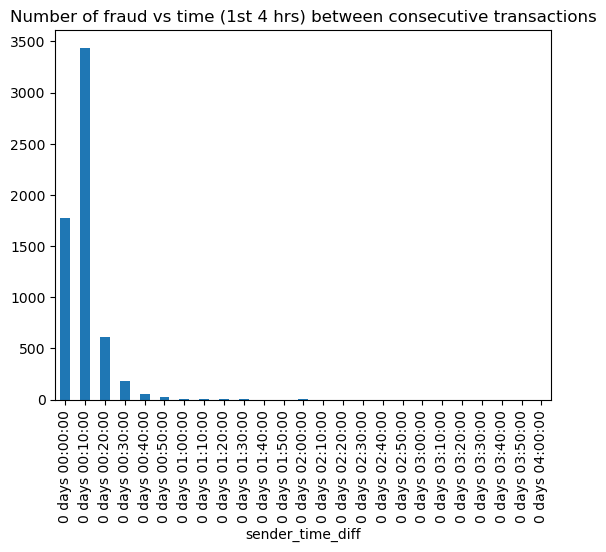

In [58]:
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('10min').Label.count().head(25).plot(kind='bar')
plt.title('Number of fraud vs time (1st 4 hrs) between consecutive transactions')

In [59]:
JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1D').Label.count()

sender_time_diff
0 days     8872
1 days      699
2 days      153
3 days      106
4 days       64
5 days       66
6 days       55
7 days       40
8 days       28
9 days       22
10 days      23
11 days      13
12 days      12
13 days      12
14 days       6
15 days       1
16 days       7
17 days       2
18 days       5
19 days       2
20 days       0
21 days       3
22 days       1
23 days       2
24 days       1
25 days       2
26 days       0
27 days       1
28 days       0
29 days       0
30 days       0
31 days       1
32 days       0
33 days       0
34 days       0
35 days       0
36 days       0
37 days       0
38 days       1
39 days       0
40 days       1
Freq: D, Name: Label, dtype: int64

In [60]:
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('1D').Label.count()

sender_time_diff
0 days     403674
1 days      40401
2 days       7662
3 days       7158
4 days       8651
5 days       8829
6 days       6037
7 days       2647
8 days       1080
9 days        756
10 days       582
11 days       433
12 days       310
13 days       269
14 days       222
15 days       165
16 days       122
17 days       129
18 days        99
19 days        79
20 days        65
21 days        55
22 days        42
23 days        39
24 days        35
25 days        29
26 days        26
27 days        22
28 days        34
29 days        19
30 days        17
31 days        10
32 days        11
33 days         9
34 days        12
35 days         2
36 days         8
37 days         7
38 days         4
39 days         8
40 days         3
41 days        13
42 days         3
43 days         5
44 days         5
45 days         4
46 days         2
47 days         2
48 days         1
49 days         1
50 days         0
51 days         0
52 days         1
Freq: D, Name: Label, dtype: 

Text(0.5, 1.0, 'Number non-fraud vs time (hours) btwn consecutive sender transaction')

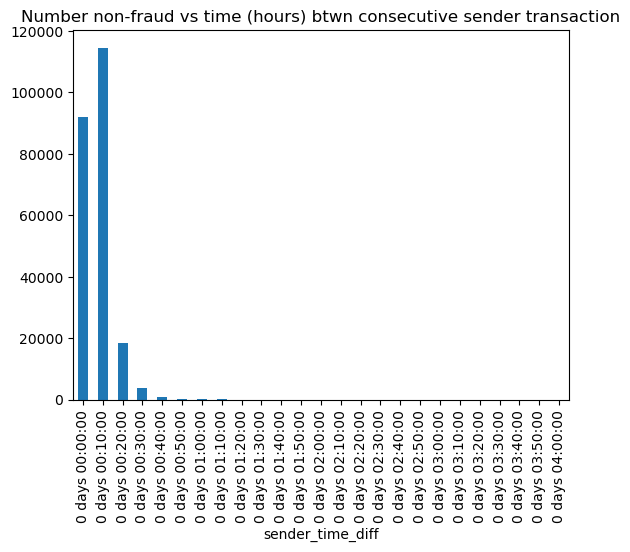

In [61]:
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('10min').Label.count().head(25).plot(kind='bar')
plt.title('Number non-fraud vs time (hours) btwn consecutive sender transaction')

Text(0.5, 1.0, 'Number all transactions vs time (1st 4 hours) btwn consecutive sender transaction')

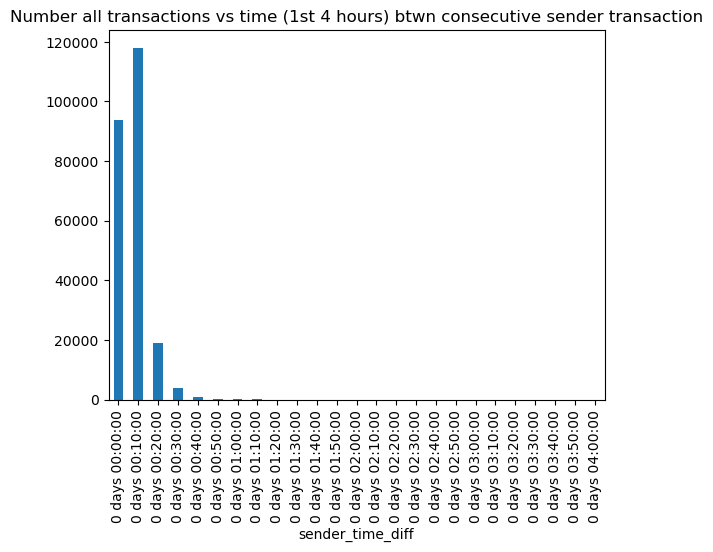

In [62]:
# Number of all transactions vs time (first 4 hours) between consecutive sender transactions
JPfraud.set_index('sender_time_btwn').resample('10min').Label.count().head(25).plot(kind='bar')
plt.title('Number all transactions vs time (1st 4 hours) btwn consecutive sender transaction')

Text(0.5, 1.0, 'Number non-fraud vs time (days) btwn consecutive sender transaction')

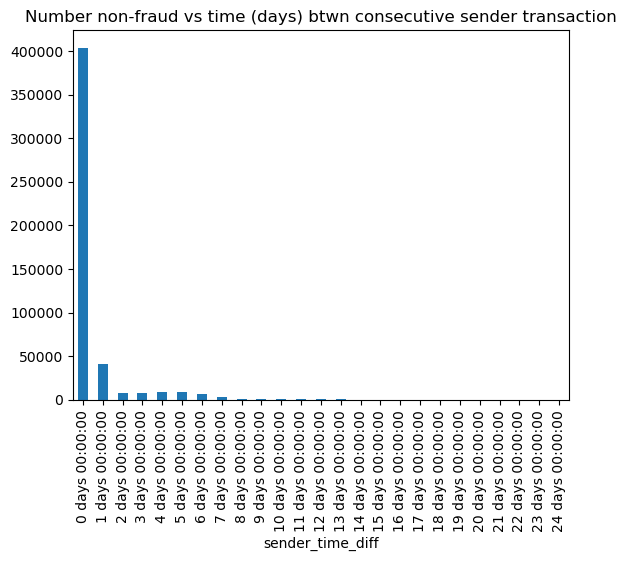

In [63]:
# Number of non-fraud transactions vs time (first four hours) between consecutive sender transactions
JPfraud[JPfraud.Label == 0].set_index('sender_time_btwn').resample('1D').Label.count().head(25).plot(kind='bar')
plt.title('Number non-fraud vs time (days) btwn consecutive sender transaction')

Text(0.5, 1.0, 'Number of transactions vs time (days) btwn consecutive sender transaction')

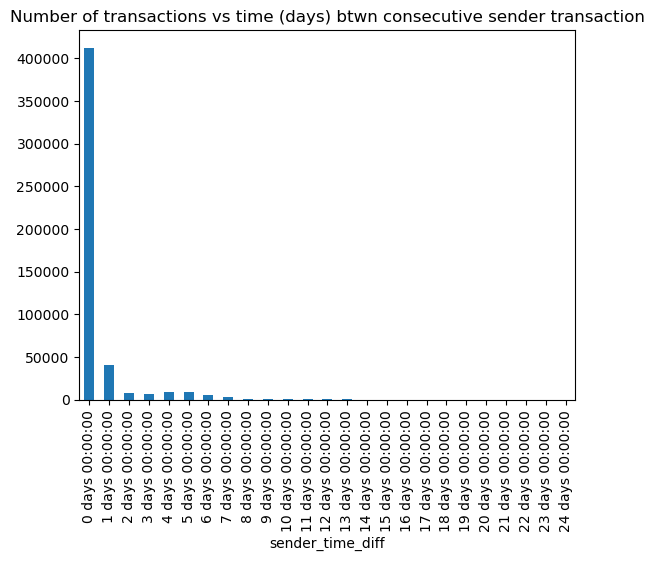

In [64]:
# Number of all transactions vs days between consecutive sender transactions
JPfraud.set_index('sender_time_btwn').resample('1D').Label.count().head(25).plot(kind='bar')
plt.title('Number of transactions vs time (days) btwn consecutive sender transaction')

In [65]:
JPfraud.bene_time_diff.describe()

count                       500000
mean     2 days 02:29:54.674399999
std      4 days 17:33:19.863326658
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 12:00:00
75%                2 days 00:00:00
max               57 days 13:00:00
Name: bene_time_diff, dtype: object

In [66]:
# Number of fraud, bene transactions vs time between last transactions, 10-minute distribution
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('10min').Label.count()

bene_time_diff
0 days 00:00:00     3034
0 days 00:10:00     1260
0 days 00:20:00      428
0 days 00:30:00      217
0 days 00:40:00       89
                    ... 
48 days 01:50:00       0
48 days 02:00:00       0
48 days 02:10:00       0
48 days 02:20:00       0
48 days 02:30:00       1
Freq: 10T, Name: Label, Length: 6928, dtype: int64

In [67]:
# Number of fraud, bene transactions vs time between last transactions, 10-minute distribution (first 4 hours)
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('10min').Label.count().head(25)

bene_time_diff
0 days 00:00:00    3034
0 days 00:10:00    1260
0 days 00:20:00     428
0 days 00:30:00     217
0 days 00:40:00      89
0 days 00:50:00      45
0 days 01:00:00      21
0 days 01:10:00      17
0 days 01:20:00       2
0 days 01:30:00       2
0 days 01:40:00       1
0 days 01:50:00       1
0 days 02:00:00       0
0 days 02:10:00       0
0 days 02:20:00       0
0 days 02:30:00       0
0 days 02:40:00       0
0 days 02:50:00       0
0 days 03:00:00       0
0 days 03:10:00       0
0 days 03:20:00       0
0 days 03:30:00       0
0 days 03:40:00       0
0 days 03:50:00       0
0 days 04:00:00       0
Freq: 10T, Name: Label, dtype: int64

In [68]:
# Number of non-fraud, bene transactions vs time between last transactions, 10-minute distribution
JPfraud[JPfraud.Label == 0].set_index('bene_time_btwn').resample('10min').Label.count().head(25)

bene_time_diff
0 days 00:00:00    162229
0 days 00:10:00     30800
0 days 00:20:00     14844
0 days 00:30:00      6068
0 days 00:40:00      2489
0 days 00:50:00      1058
0 days 01:00:00       393
0 days 01:10:00       155
0 days 01:20:00        93
0 days 01:30:00        26
0 days 01:40:00         7
0 days 01:50:00         4
0 days 02:00:00         2
0 days 02:10:00         0
0 days 02:20:00         0
0 days 02:30:00         0
0 days 02:40:00         0
0 days 02:50:00         0
0 days 03:00:00         0
0 days 03:10:00         0
0 days 03:20:00         0
0 days 03:30:00         0
0 days 03:40:00         0
0 days 03:50:00         0
0 days 04:00:00         0
Freq: 10T, Name: Label, dtype: int64

In [69]:
JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('1D').Label.count()

bene_time_diff
0 days     6880
1 days     1225
2 days      454
3 days      246
4 days      192
5 days      135
6 days      113
7 days      100
8 days       90
9 days       82
10 days      53
11 days      62
12 days      55
13 days      54
14 days      44
15 days      43
16 days      34
17 days      31
18 days      22
19 days      32
20 days      27
21 days      24
22 days      16
23 days      20
24 days      16
25 days      18
26 days      20
27 days      16
28 days      10
29 days       9
30 days       6
31 days      15
32 days      10
33 days      11
34 days       6
35 days       3
36 days       2
37 days       9
38 days       1
39 days       2
40 days       5
41 days       2
42 days       1
43 days       1
44 days       1
45 days       0
46 days       1
47 days       1
48 days       1
Freq: D, Name: Label, dtype: int64

In [70]:
JPfraud[JPfraud.Label == 0].set_index('bene_time_btwn').resample('1D').Label.count()

bene_time_diff
0 days     285465
1 days      80714
2 days      33156
3 days      17739
4 days      14118
5 days      12110
6 days       8898
7 days       5409
8 days       3568
9 days       2827
10 days      2415
11 days      2313
12 days      2006
13 days      1793
14 days      1703
15 days      1427
16 days      1361
17 days      1258
18 days      1134
19 days      1095
20 days      1011
21 days       909
22 days       763
23 days       724
24 days       688
25 days       588
26 days       526
27 days       530
28 days       487
29 days       399
30 days       403
31 days       323
32 days       260
33 days       253
34 days       239
35 days       206
36 days       166
37 days       143
38 days       121
39 days        97
40 days       100
41 days        68
42 days        49
43 days        64
44 days        39
45 days        45
46 days        19
47 days        19
48 days        16
49 days        12
50 days         8
51 days         4
52 days         4
53 days         4
54 days      

In [71]:
timeDiffcompare = pd.concat([JPfraud[JPfraud.Label == 1].set_index('sender_time_btwn').resample('1D').Label.count(),
                             JPfraud[JPfraud.Label == 1].set_index('bene_time_btwn').resample('1D').Label.count()],
                             keys=['sender_time_btwn','bene_time_btwn'],
                             axis=1).fillna(0)
timeDiffcompare.index = timeDiffcompare.index.days
timeDiffcompare

,sender_time_diff,bene_time_diff
0,8872.0,6880
1,699.0,1225
2,153.0,454
3,106.0,246
4,64.0,192
5,66.0,135
6,55.0,113
7,40.0,100
8,28.0,90
9,22.0,82


<Figure size 2000x1000 with 0 Axes>

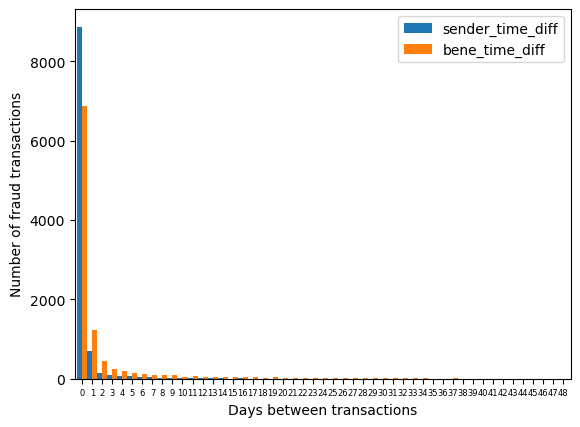

In [72]:
plt.figure(figsize=(20,10))
timeDiffcompare.plot.bar(stacked=False,width=1)
plt.xticks(fontsize=6,rotation=0)
plt.xlabel('Days between transactions')
plt.ylabel('Number of fraud transactions')
plt.show()

<font size=5> Generating time/time range features </font>

In [74]:
# Functions to convert between seconds and a time object
def convert_time_to_seconds(timeObj):
    return int((timeObj.hour)*60*60 + (timeObj.minute)*60 + (timeObj.second))

def convert_seconds_to_time(seconds):
    if pd.isna(seconds):
        return pd.NA
    
    hour = int(seconds / 3600)
    mins = int((seconds % 3600)/60)
    secs = (seconds % 3600) % 60

    return dt.time(hour,mins,secs)

In [75]:
np.linspace(0.75,1,26)

array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99, 1.  ])

In [76]:
pd.options.mode.chained_assignment = None
# Develop time range features:

# seconds_in_day: how many seconds after midnight the transaction is recorded for
JPfraud['seconds_in_day'] = JPfraud.Time_step.transform(lambda x: convert_time_to_seconds(x.time()))

perc_outside_fraud = np.zeros(len(np.linspace(0.75,1,26)))
perc_outside_general = np.zeros(len(np.linspace(0.75,1,26)))
data_length = len(JPfraud)
data_fraud_length = len(JPfraud[JPfraud.Label == 1])

for j, quant in enumerate(np.linspace(0.75,1,26)):

# time_min_out: expanding quantile, i.e. at time of transaction, of lower bound on range of time for
#               regular transactions of sender (in seconds after midnight)
    JPfraud['time_min_out'] = JPfraud.set_index('Time_step').groupby(
            'Sender_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=0)).reset_index(level=0,drop=True)

# time_max_out: expanding quantile of upper bound on range of time for regular transactions of sender
#               (in seconds after midnight)
    JPfraud['time_max_out'] = JPfraud.set_index('Time_step').groupby(
            'Sender_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=quant)).reset_index(level=0,drop=True)

# time_min_in: expanding quantile of lower bound on range of time for regular transactions of
#               beneficiary (in seconds after midnight)
    JPfraud['time_min_in'] = JPfraud.set_index('Time_step').groupby(
            'Bene_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=0)).reset_index(level=0,drop=True)

# time_max_in: expanding quantile of upper bound on range of time for regular transactions of
#               beneficiary (in seconds after midnight)
    JPfraud['time_max_in'] = JPfraud.set_index('Time_step').groupby(
            'Bene_Account',sort=False)['seconds_in_day'].transform(
            lambda x: x.expanding(method='single').quantile(q=quant)).reset_index(level=0,drop=True)

# outside_time_bene_range: indicator of whether transaction is outside range for beneficiary at
#                          time of transaction, 0 no, 1 yes
# outside_time_sender_range: indicator of whether transaction is outside usual time range for sender
#                            at time of transaction, 0 no, 1 yes
    JPfraud = JPfraud.assign(outside_time_bene_range = lambda x: ((x.seconds_in_day < x.time_min_in) | (x.seconds_in_day > x.time_max_in))*1)
    JPfraud = JPfraud.assign(outside_time_sender_range = lambda x: ((x.seconds_in_day < x.time_min_out) | (x.seconds_in_day > x.time_max_out))*1)

    perc_outside_fraud[j] = (JPfraud[JPfraud.Label == 1].outside_time_bene_range.sum() +
                             JPfraud[JPfraud.Label == 1].outside_time_sender_range.sum())/data_fraud_length
    perc_outside_general[j] = (JPfraud.outside_time_bene_range.sum() +
                             JPfraud.outside_time_sender_range.sum())/data_length
    print([perc_outside_fraud[j],perc_outside_general[j]])
    

#JPfraud

[0.6075874914224095, 0.574334]
[0.6057249289285365, 0.571576]
[0.5984707381629252, 0.564684]
[0.5905303401627291, 0.556544]
[0.5853347711008725, 0.550262]
[0.5707283599647094, 0.53418]
[0.5683756494461327, 0.53072]
[0.5626899323595725, 0.523624]
[0.5586707185570042, 0.518418]
[0.5474953435937653, 0.506012]
[0.5392608567787471, 0.499382]
[0.529457896284678, 0.489448]
[0.5241642976178806, 0.483652]
[0.5157337515929811, 0.474576]
[0.5069110871483188, 0.465642]
[0.4999509851975297, 0.458312]
[0.4930889128516812, 0.451902]
[0.48710910695029896, 0.445378]
[0.480737182629154, 0.438376]
[0.47387511028330553, 0.43165]
[0.4663268307028723, 0.423734]
[0.4612292912459563, 0.417196]
[0.45632781099892167, 0.411782]
[0.45172041956670916, 0.40711]
[0.45162238996176846, 0.406218]
[0.0, 0.0]


In [ ]:
plt.figure()
plt.scatter(np.linspace(0.75,1,26),perc_outside_fraud,label='fraud percentage')
plt.scatter(np.linspace(0.75,1,26),perc_outside_general,label='general percentage')
plt.xlabel('Upper quantile percentage, lower 0%')
plt.ylabel('Percentage')
plt.legend()

plt.show()

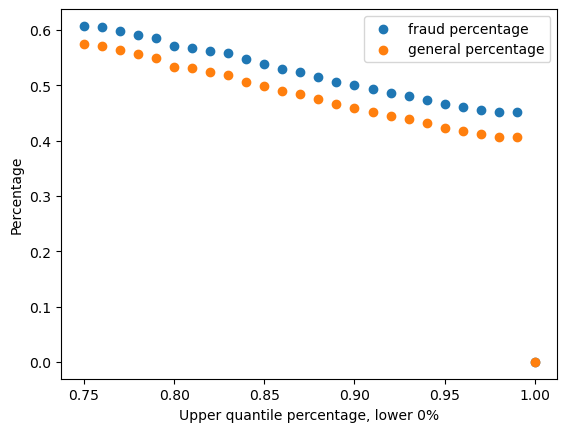

In [77]:
plt.figure()
plt.scatter(np.linspace(0.75,1,26),perc_outside_fraud,label='fraud percentage')
plt.scatter(np.linspace(0.75,1,26),perc_outside_general,label='general percentage')
plt.xlabel('Upper quantile percentage, lower 0%')
plt.ylabel('Percentage')
plt.legend()

plt.show()

In [83]:
time_features = JPfraud[['Time_step','Label','seconds_in_day','outside_time_bene_range','outside_time_sender_range']]
time_features

In [85]:
def label_time_range(seconds):
    return int(seconds/3600) + 1

In [87]:
# transaction_hour: hour of transaction within a day
time_features['transaction_hour'] = time_features.seconds_in_day.apply(label_time_range)
time_features

In [ ]:
(time_features[time_features.Label == 1].outside_time_bene_range.sum() +
time_features[time_features.Label == 1].outside_time_sender_range.sum())/len(time_features[time_features.Label == 1])

In [ ]:
(time_features.outside_time_bene_range.sum() + time_features.outside_time_sender_range.sum())/len(time_features)

In [ ]:
time_features.to_csv('data/time_features.csv')

In [ ]:
time_features[time_features.Label == 1].groupby('transaction_hour').Label.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of frauds')
plt.ylim([0,700])
plt.show()

In [ ]:
time_features[time_features.outside_time_bene_range == 1].groupby('transaction_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range IN transactions')
plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[time_features.outside_time_sender_range == 1].groupby('trans_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of outside time range OUT transactions')
plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[((time_features.outside_time_sender_range == 1) & (time_features.Label == 1))].groupby(
    'trans_hour').outside_time_sender_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range OUT transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
time_features[((time_features.outside_sender_bene_range == 1) & (time_features.Label == 1))].groupby(
    'trans_hour').outside_time_bene_range.value_counts().plot(kind='bar')
plt.xlabel('Hour of day')
plt.ylabel('Number of fraudulent outside time range IN transactions')
#plt.ylim([0,14000])
plt.show()

In [ ]:
JPfraud.loc[JPfraud.Sender_Id == sendIDs[9]].USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].values

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
#sender_fraud_stat_amounts = JPfraud.loc[JPfraud.Label == 1].groupby(
#    'Sender_Id').USD_amount.agg('describe')[['std','min','25%','50%','mean','75%','max']].reset_index()
#sender_fraud_stat_amounts

In [ ]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].outside_time_out_range.sum()

In [ ]:
JPfraud[JPfraud.Bene_Id == 'CLIENT-725719'].Label.sum()

In [ ]:
JPfraud[JPfraud.Sender_Account == 'ACCOUNT-9825']